# Decision Trees and Random Forests with Divvy Bikeshare Data

> This notebook takes another look at the Chicago Bikeshare Data, specifically in the context of Decision Tree and Random Forest modeling.  Below, a variety of instances are run for each model in an attempt to compare and classify their accuracy and computational efficiency.

> These initial cells import the modules necessary to read the data and generate the models.  Since this particular dataset is relatively large, I have made some subgroups of the data (by year) and have selected the columns which should be easiest to run, yet most relevant to the discussion below.

In [176]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import ensemble
from sklearn import tree
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score
import scipy
import seaborn as sns
import pydotplus.graphviz
from datetime import datetime

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

%matplotlib inline

In [2]:
# Setting the colors:

palette_1 = sns.diverging_palette(220, 7, s = 60, l = 50, n=8)
sns.set(palette = 'YlGnBu')

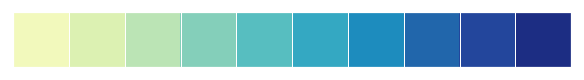

In [3]:
sns.palplot(sns.color_palette('YlGnBu', 10))

In [4]:
column_list = ['trip_id', 'year', 'month', 'week', 'day', 'hour', 'usertype', 'gender', 'starttime',
                'stoptime', 'tripduration', 'temperature', 'events', 'from_station_id',
                'dpcapacity_start', 'to_station_id', 'dpcapacity_end']

In [5]:
data = pd.read_csv("Divvy_Bikeshare.csv", index_col = False, usecols = column_list)

In [6]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

In [7]:
# Cleaning/Isolating the data related to weather, which should be fun to look at:

data_wthr = data.replace({'events': {'clear':0,
                                     'cloudy':1,
                                     'not clear':2,
                                     'rain or snow':3,
                                     'tstorms':4,
                                     'unknown':5}})

yr_2017 = pd.DataFrame(data_wthr.loc[data_wthr['year'] == 2017])

In [8]:
dumb_data = pd.get_dummies(data_wthr)
dumb_data_17 = pd.get_dummies(yr_2017)

In [9]:
dumb_data_17.keys()

Index(['trip_id', 'year', 'month', 'week', 'day', 'hour', 'starttime',
       'stoptime', 'tripduration', 'temperature', 'events', 'from_station_id',
       'dpcapacity_start', 'to_station_id', 'dpcapacity_end',
       'usertype_Customer', 'usertype_Dependent', 'usertype_Subscriber',
       'gender_Female', 'gender_Male'],
      dtype='object')

## Random Forest Models:

> Below our the first functions for testing out our Random Forest models.  The functions allow different targets to be changed in relation to a group of input variables relatively easily.  I will describe the characteristics that I found below throughout the cells..

> With the first two functions, I used a larger number of input variables to gain a general overview of the dataset in relation to a few different classes of target variables.  In the first function, the forest classifier is looking at the types of user that can be predicted.  The second function swaps the gender variables with the user variables. As such, it attempts to predict the gender based on user-variable inputs (the rest of the inputs remain the same as the first classifier).  Beyond these first two functions, I try to reduce the input variables in various stages so as to see how this forest model compares to a single decision tree.


In [112]:
def forest_classifier(target):
    
    rfc = ensemble.RandomForestClassifier()

    X = dumb_data_17[['day', 'month', 'week', 'tripduration', 'temperature', 'events',
                      'gender_Male', 'gender_Female']]
    Y = dumb_data_17[target].values
    
    rfc.fit(X, Y)
    
    return cross_val_score(rfc, X, Y, cv = 10)


In [113]:
forest_classifier('usertype_Customer')

array([0.999716  , 0.78388275, 0.61358695, 0.48598399, 0.46706382,
       0.20983944, 0.39279302, 0.20269535, 0.99971937, 0.99971599])

In [181]:
start_time = datetime.now()
forest_classifier('usertype_Customer')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:05:52.922891


In [115]:
forest_classifier('usertype_Subscriber')

array([0.99971261, 0.74830443, 0.74435541, 0.29602056, 0.1236235 ,
       0.13606903, 0.2577696 , 0.12426294, 0.99969909, 0.99968556])

In [182]:
start_time = datetime.now()
forest_classifier('usertype_Subscriber')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:04:59.843661


> While these scores do reach a high accuracy at some points, there is too much variance throughout the whole of those scores to demonstrate reliability.  My guess is that this model is dealing with quite a bit more information than the models we will see below.  As a result, you would want to narrow your input variables to hopefully pinpoint your accuracy.

> Narrowing your input variables would also increase your runtime.  Given that our runtime here is just under six minutes, you would probably want to try and narrow your runtime as much as possible.

In [116]:
# Used input variables related to weather, battery power and tripduration to see conditions for user-types:

def simpler_forest(target):

    rfc1 = ensemble.RandomForestClassifier()
    
    X1 = dumb_data_17[['month', 'temperature', 'events', 'dpcapacity_start', 'tripduration', 'usertype_Dependent',
                       'usertype_Subscriber','usertype_Customer']]
    Y1 = dumb_data_17[target].values
    
    rfc1.fit(X1, Y1)
    
    return cross_val_score(rfc1, X1, Y1, cv = 10)

In [117]:
simpler_forest('gender_Female')

array([0.71127565, 0.47310908, 0.60426211, 0.67225098, 0.65218126,
       0.63727436, 0.64067904, 0.56270603, 0.51401939, 0.67832896])

In [183]:
start_time = datetime.now()
simpler_forest('gender_Female')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:08:49.575056


In [118]:
simpler_forest('gender_Male')

array([0.69652771, 0.46294913, 0.59069747, 0.66140806, 0.63353834,
       0.62234041, 0.62541375, 0.54581447, 0.5098844 , 0.66364177])

In [184]:
start_time = datetime.now()
simpler_forest('gender_Male')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:09:03.988208


> While these scores demonstrate a significant improvement in their variation between folds, they are still not quite reliable for us to use for prediction's sake. In reality, you would want a set of scores with only two or three points in variation either way. I imagine the runtime is nearly doubled as a result of adding the battery capacity variable ('dpcapacity_start')

In [119]:
# Variables related to time of year/season and type of subscriber - are there more dependents during the summer?:

def simpler_forest_2(target):

    rfc2 = ensemble.RandomForestClassifier()
    
    X2 = dumb_data_17[['month', 'events', 'tripduration']]
    Y2 = dumb_data_17[target].values
    
    rfc2.fit(X2, Y2)
    
    return cross_val_score(rfc2, X2, Y2, cv = 10)    

In [121]:
simpler_forest_2('gender_Male')

array([0.74179599, 0.49418634, 0.72835557, 0.74255923, 0.74321853,
       0.73847158, 0.7399457 , 0.72163411, 0.52897024, 0.74043845])

In [185]:
start_time = datetime.now()
simpler_forest_2('gender_Male')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:08:00.997414


In [122]:
simpler_forest_2('usertype_Customer')

array([0.99971261, 0.99947933, 0.99969909, 0.99947256, 0.99969571,
       0.99968557, 0.99971261, 0.97945018, 0.99971937, 0.99971937])

In [186]:
start_time = datetime.now()
simpler_forest('usertype_Customer')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:01:31.950404


This model was able to offer a reliable prediction for the Customer Usertype variable. The gender variable, however, is less reliable, although slightly improved over the models before it. 

I am a little surprised as to why the runtime is so different between the two - especially since they are using the same portion of the dataset as input.  It could, however, have been some other programs running on my computer.  I would probably try and check this timing again if I were going to implement it in a real scenario.

In [127]:
# Getting as simple as possible:

def simpler_forest_3(target):

    rfc3 = ensemble.RandomForestClassifier()
    
    X3 = dumb_data_17[['month']]
    Y3 = dumb_data_17[target].values
    
    rfc3.fit(X3, Y3)
    
    return cross_val_score(rfc3, X3, Y3, cv = 10) 

In [128]:
simpler_forest_3('usertype_Subscriber')

array([0.999716  , 0.999716  , 0.999716  , 0.999716  , 0.99971599,
       0.99971599, 0.99971937, 0.99971937, 0.99971937, 0.99971937])

In [178]:
start_time = datetime.now()
simpler_forest_3('usertype_Subscriber')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:00:51.930549


In [129]:
simpler_forest_3('gender_Male')

array([0.75003888, 0.49424044, 0.75003804, 0.75003804, 0.75003804,
       0.75003804, 0.75003804, 0.75003804, 0.40208068, 0.75004057])

In [180]:
start_time = datetime.now()
simpler_forest_3('gender_Male')
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

Runtime: 0:00:59.292672


> These models give us a much better runtime and still maintain the accuracy of the Subscriber usertype. As such, you would probably want to go with a model like this. 

> Overall, the random forest models are quite reliable since they run multiple versions of decision trees and therefore provide an accuracy score with a heavier background of testing.  Based on my experience in this notebook, it seems as if they are a little easier to customize regarding the input variables as you can specify which variables you would like to use right within the classifier. With the decision trees below I had to create a new dataframe. I will discuss it further down below, but it does seem as if this is the more powerful and reliable model of the two.

In [109]:
def holdout_forest(target):
    
    rfc4 = ensemble.RandomForestClassifier()
    
    X4 = dumb_data_17[['month', 'gender_Male', 'gender_Female', 'tripduration', 'temperature']]
    Y4 = dumb_data_17[target].values
    
    X_Train, Y_Train, x_test, y_test = train_test_split(X4, Y4, test_size = 0.2, random_state = 20)
    rfc4.fit(X4, Y4)
    rfc4.fit(X_Train, Y_Train)
    
    return (rfc4.score(X4, Y4), rfc4.score(x_test, y_test))

## Decision Trees Models:

In [148]:
simple_data_17 = dumb_data_17[['month', 'week', 'day', 'hour', 'tripduration', 'temperature', 'events']]
simple_data_17_2 = dumb_data_17[['gender_Male', 'gender_Female', 'usertype_Customer', 'usertype_Subscriber']]

In [149]:
def tree_1(a, b, dataset, dataset1):
    
    d_tree = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        max_features = a,
        max_depth = b)

    d_tree.fit(dataset, dataset1)
    
    dot_data = tree.export_graphviz(d_tree, 
        out_file=None, feature_names = simple_data_17.columns,
        class_names=["Not_Attribute", "Attribute"],
        filled=True)

    graph = pydotplus.graph_from_dot_data(dot_data)
    
    print("The mean accuracy score for this tree is: {}.".format(d_tree.score(X = dataset, y = dataset1)))
    print("The CV score for this model is: \n {}.".format(cross_val_score(d_tree, dataset, dataset1, cv = 10)))
  
    return Image(graph.create_png())

The mean accuracy score for this tree is: 0.7500383745422948.
The CV score for this model is: 
 [0.75003888 0.74908797 0.61003351 0.75003804 0.75003804 0.75003804
 0.75003804 0.75003804 0.75003804 0.75004057].


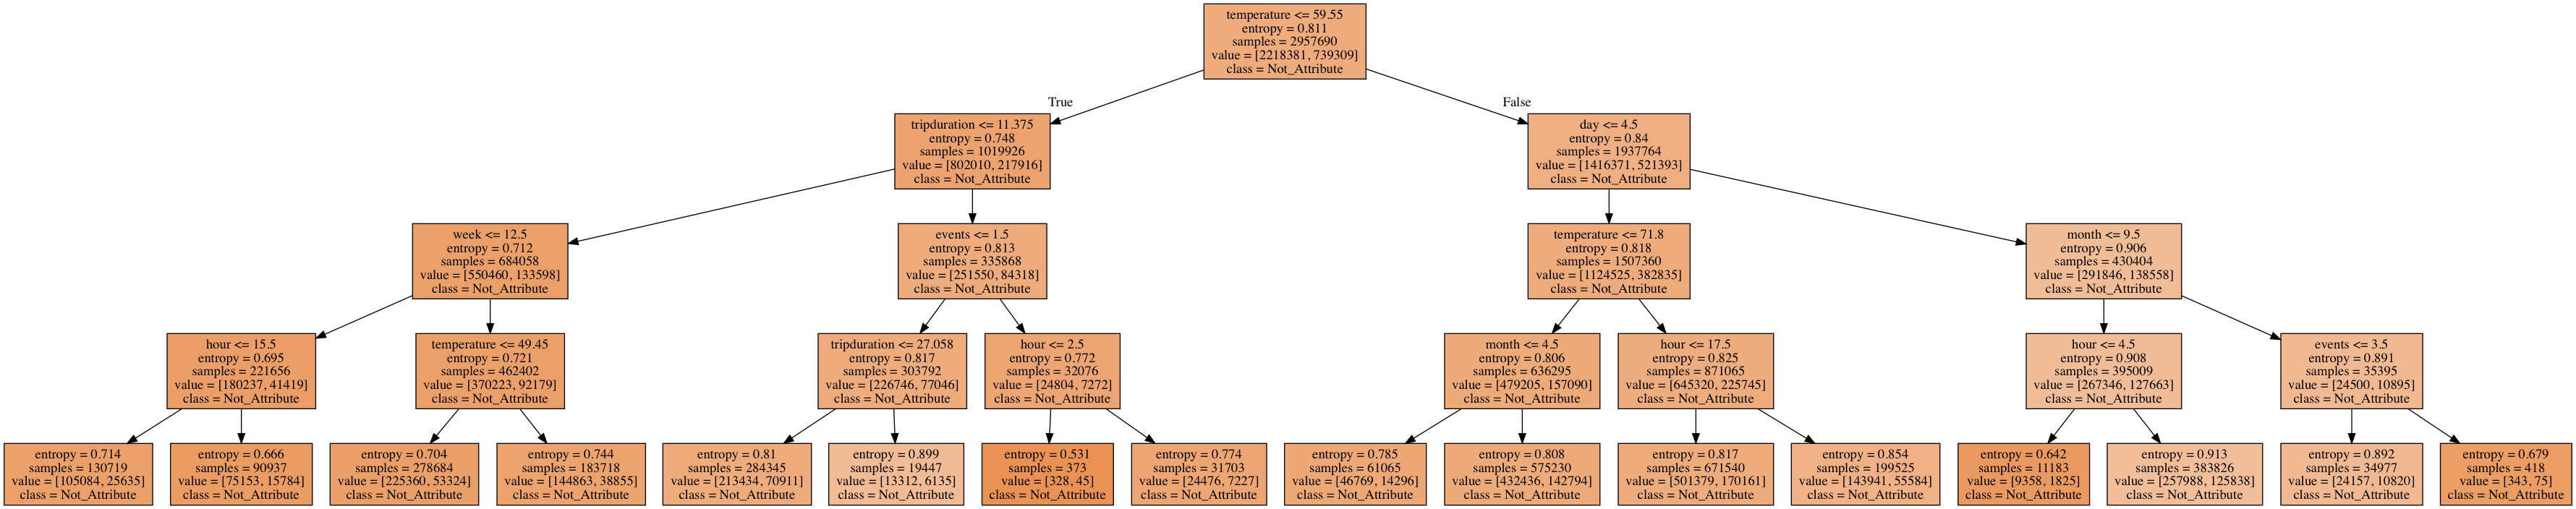

In [151]:
tree_1(1, 4, simple_data_17, simple_data_17_2.gender_Female)

In [187]:
start_time = datetime.now()
tree_1(1, 4, simple_data_17, simple_data_17_2.gender_Female)
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

The mean accuracy score for this tree is: 0.7500383745422948.
The CV score for this model is: 
 [0.75003888 0.5159939  0.43158343 0.75003804 0.75003804 0.75003804
 0.75003804 0.75003804 0.75003804 0.75004057].
Runtime: 0:00:14.636081


The mean accuracy score for this tree is: 0.7500383745422948.
The CV score for this model is: 
 [0.75003888 0.69442031 0.74745156 0.75003804 0.75003804 0.75003804
 0.75003804 0.75000085 0.75003804 0.75004057].


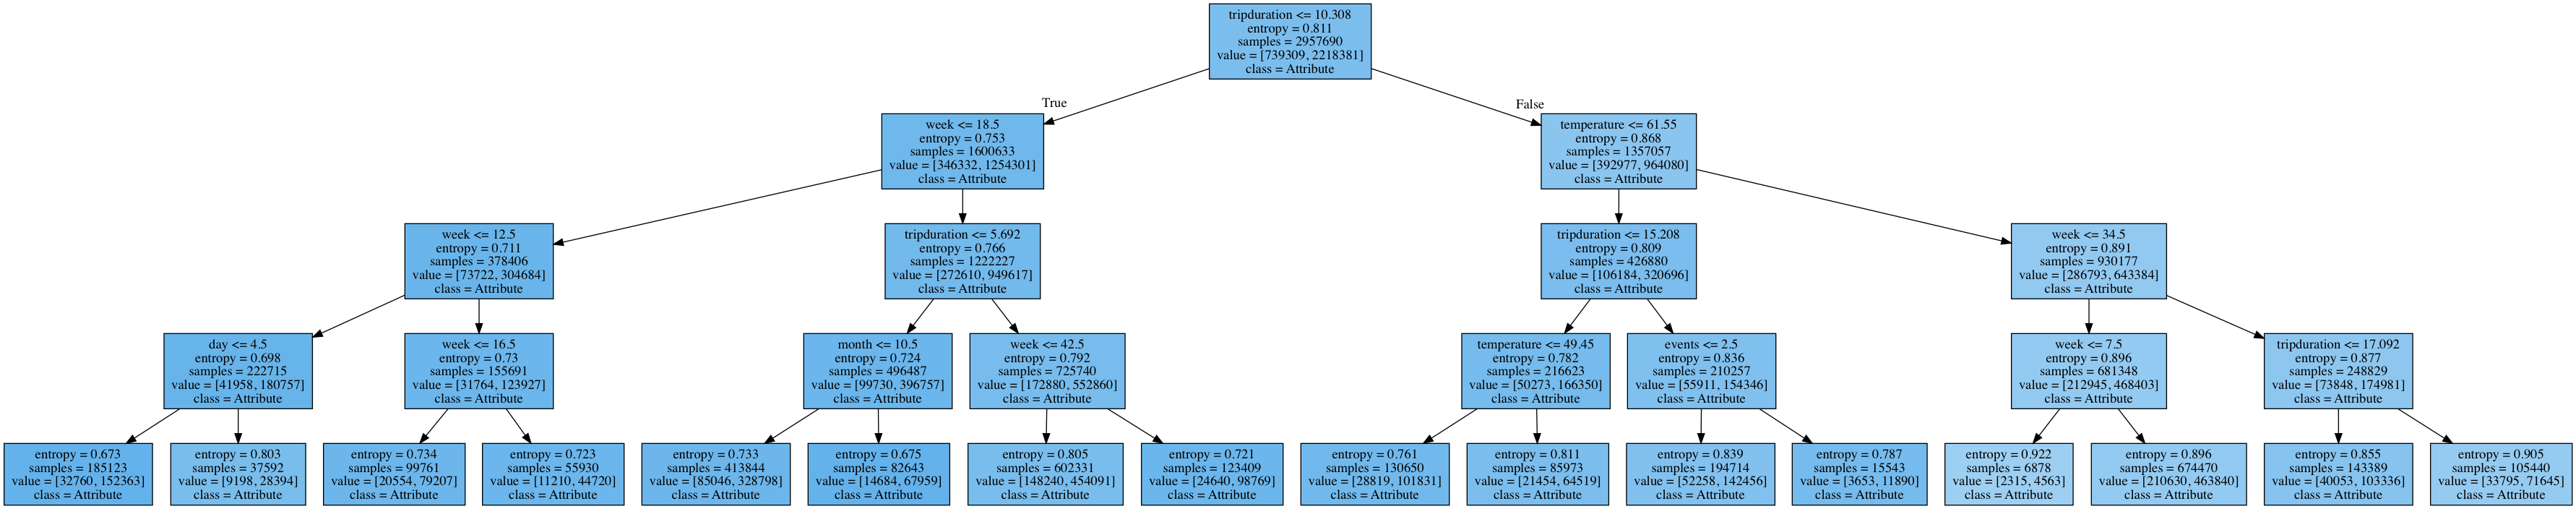

In [152]:
tree_1(1, 4, simple_data_17, simple_data_17_2.gender_Male)

In [188]:
start_time = datetime.now()
tree_1(1, 4, simple_data_17, simple_data_17_2.gender_Male)
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

The mean accuracy score for this tree is: 0.7500383745422948.
The CV score for this model is: 
 [0.75003888 0.66560728 0.75003804 0.75003804 0.75003804 0.75003804
 0.75003804 0.75003804 0.75003804 0.75004057].
Runtime: 0:00:12.214405


The mean accuracy score for this tree is: 0.9997173469836257.
The CV score for this model is: 
 [0.999716   0.9839267  0.999716   0.84815566 0.57720721 0.63857605
 0.57266844 0.99971937 0.99971937 0.99971937].


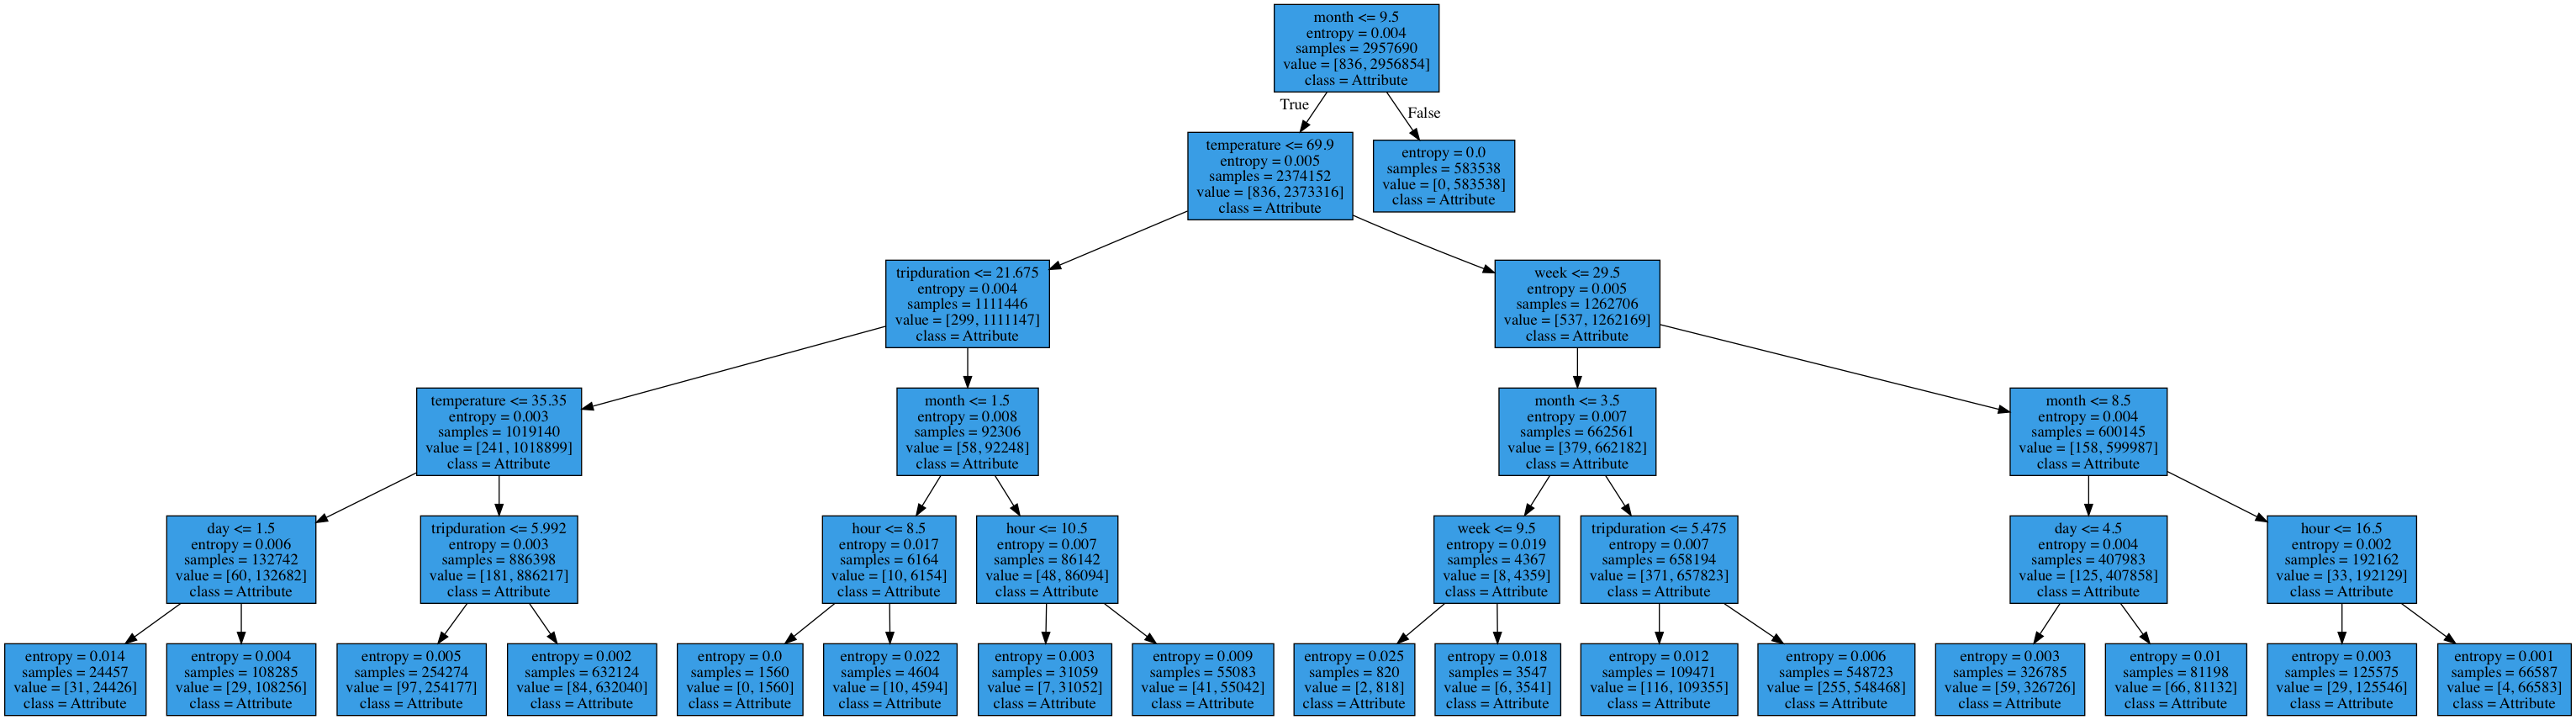

In [155]:
tree_1(1, 5, simple_data_17, simple_data_17_2.usertype_Subscriber)

In [189]:
start_time = datetime.now()
tree_1(1, 5, simple_data_17, simple_data_17_2.usertype_Subscriber)
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

The mean accuracy score for this tree is: 0.9997173469836257.
The CV score for this model is: 
 [0.999716   0.98630017 0.999716   0.999716   0.99971599 0.99971599
 0.99971937 0.99971937 0.99971937 0.99971937].
Runtime: 0:00:13.001631


The mean accuracy score for this tree is: 0.9997173469836257.
The CV score for this model is: 
 [0.999716   0.999716   0.999716   0.97084897 0.99971599 0.99971599
 0.99971937 0.77822144 0.99971937 0.99971937].


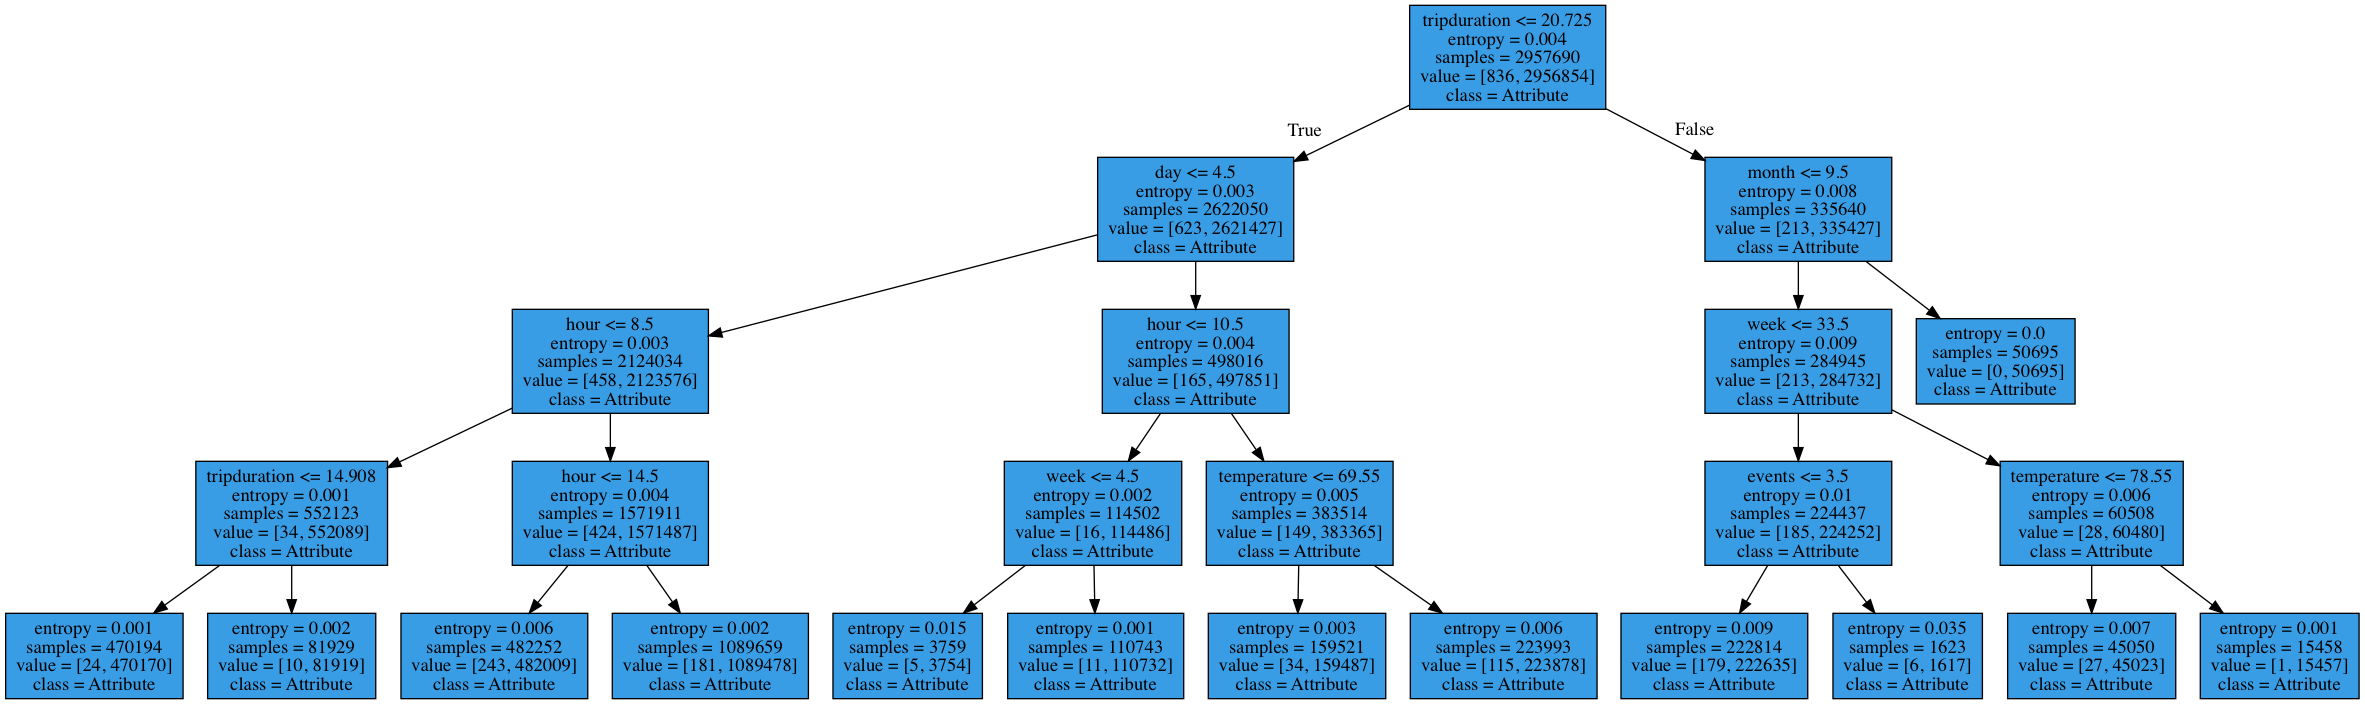

In [154]:
tree_1(1, 4, simple_data_17, simple_data_17_2.usertype_Subscriber)

In [190]:
start_time = datetime.now()
tree_1(1, 4, simple_data_17, simple_data_17_2.usertype_Subscriber)
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

The mean accuracy score for this tree is: 0.9997173469836257.
The CV score for this model is: 
 [0.999716   0.7767184  0.999716   0.999716   0.99971599 0.99971599
 0.99971937 0.99971937 0.99971937 0.99971937].
Runtime: 0:00:13.053822


In [163]:
def tree_2(a, b, dataset, dataset1):
    
    d_tree = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        max_features = a,
        max_depth = b)

    d_tree.fit(dataset, dataset1)
    
    dot_data = tree.export_graphviz(d_tree, 
        out_file=None, feature_names = modified_df_2.columns,
        class_names=["Not_Attribute", "Attribute"],
        filled=True)

    graph = pydotplus.graph_from_dot_data(dot_data)
    
    print("The mean accuracy score for this tree is: {}.".format(d_tree.score(X = dataset, y = dataset1)))
    print("The CV score for this model is: \n {}.".format(cross_val_score(d_tree, dataset, dataset1, cv = 10)))
  
    return Image(graph.create_png())

In [164]:
# Using the same constraints as the second to last random forest model:

modified_df = pd.DataFrame(dumb_data_17[['month', 'events', 'tripduration']])
modified_df_2 = pd.DataFrame(dumb_data_17[['gender_Female', 'gender_Male', 'usertype_Subscriber']])

The mean accuracy score for this tree is: 0.7500383745422948.
The CV score for this model is: 
 [0.75003888 0.62092038 0.75003804 0.75003804 0.75003804 0.75003804
 0.75003804 0.75003804 0.51342095 0.75004057].


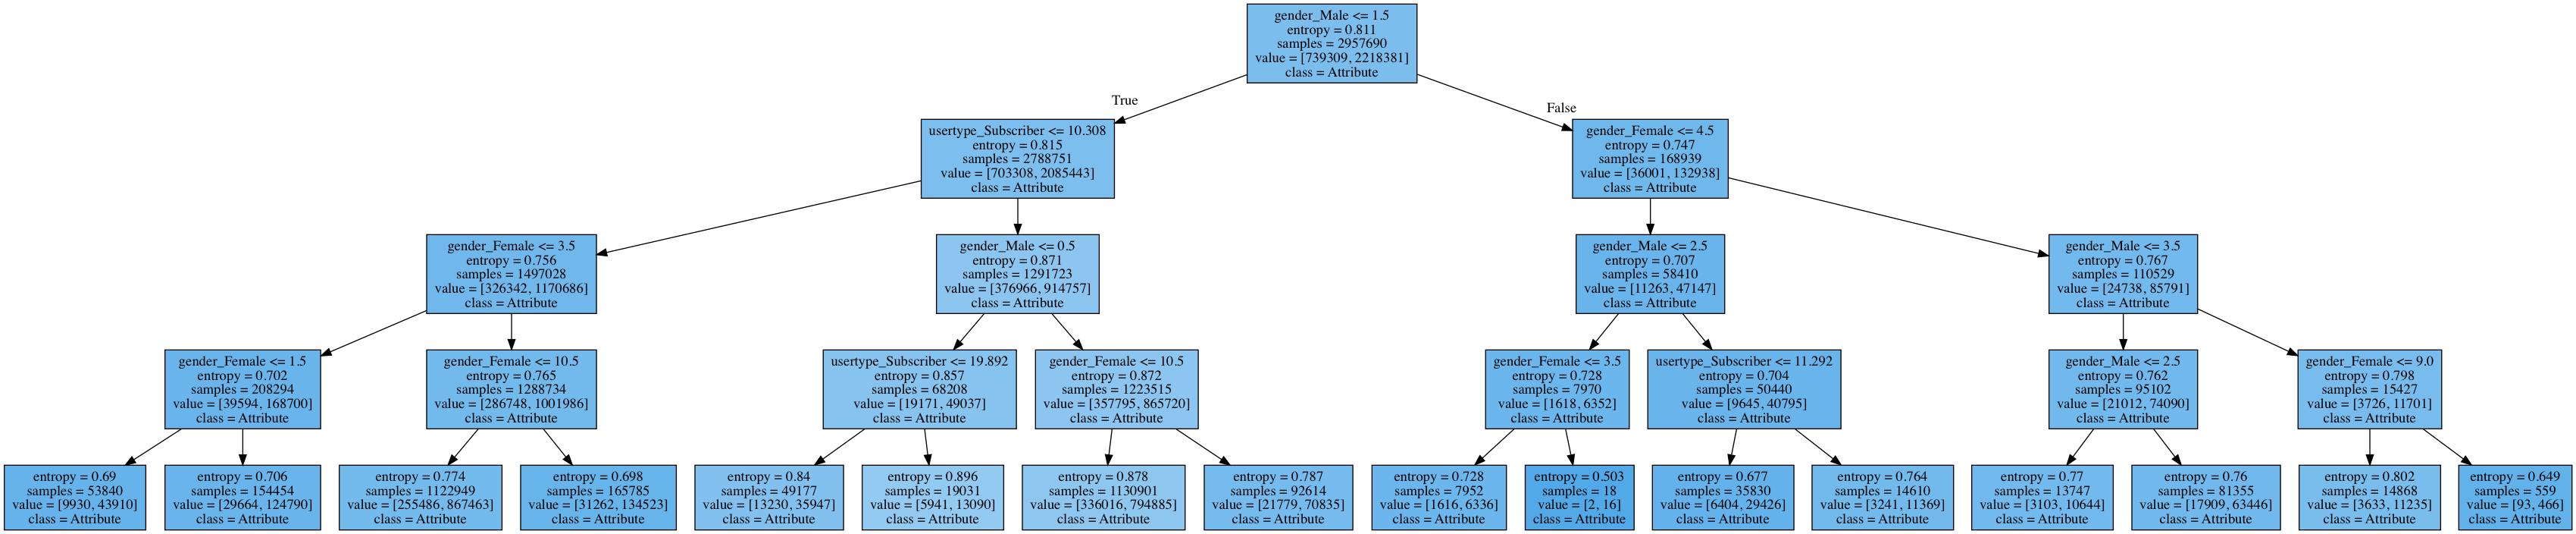

In [166]:
tree_2(1, 4, modified_df, modified_df_2.gender_Male)

In [191]:
start_time = datetime.now()
tree_2(1, 4, modified_df, modified_df_2.gender_Male)
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

The mean accuracy score for this tree is: 0.7500383745422948.
The CV score for this model is: 
 [0.75003888 0.49966697 0.75003804 0.75003804 0.75003804 0.75003804
 0.75003804 0.75003804 0.52455802 0.75004057].
Runtime: 0:00:20.191663


The mean accuracy score for this tree is: 0.9997173469836257.
The CV score for this model is: 
 [0.999716   0.999716   0.999716   0.999716   0.99971599 0.99971599
 0.99971937 0.99971937 0.99971937 0.99971937].


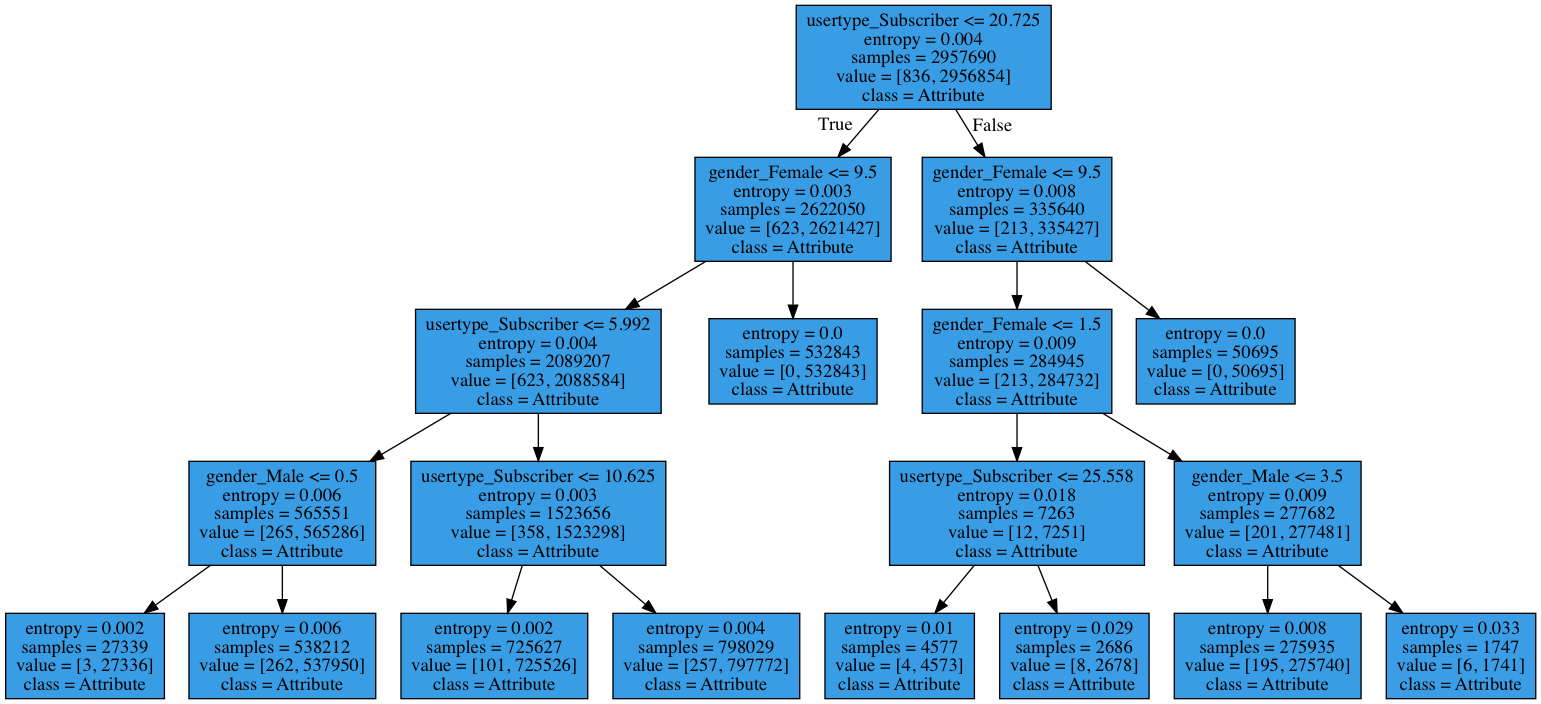

In [167]:
tree_2(1, 4, modified_df, modified_df_2.usertype_Subscriber)

In [192]:
start_time = datetime.now()
tree_2(1, 4, modified_df, modified_df_2.usertype_Subscriber)
end_time = datetime.now()
print('Runtime: {}'.format(end_time-start_time))

The mean accuracy score for this tree is: 0.9997173469836257.
The CV score for this model is: 
 [0.999716   0.999716   0.999716   0.999716   0.99971599 0.99971599
 0.99971937 0.99971937 0.99971937 0.99971937].
Runtime: 0:00:17.572614


###### Using one tree to run a separate prediction and poke around at it:

> Here, I wanted to use a model and test it against a separate part of the dataset that hadn't been touched yet. I used the data from 2017 to train the model, and then supplied input data from 2016 to compare it with the model.

In [49]:
# Making another tree to see how a gender-prediction would turn out:

d_tree = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 1,
    max_depth = 4)

d_tree.fit(simple_data_17, simple_data_17.gender_Female)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [50]:
# Creating the dataset to use for test-predictions:

dumb_data_16 = pd.DataFrame(dumb_data.loc[dumb_data['year'] == 2016])

simple_data_16 = pd.DataFrame(dumb_data_16[['month', 'week', 'day', 'hour', 'tripduration', 'temperature', 'events',
                               'usertype_Customer', 'usertype_Dependent', 'usertype_Subscriber',
                               'gender_Female', 'gender_Male']])

In [51]:
# Making the prediction and identifying the results:

x = d_tree.predict(simple_data_16)

unique_counts = np.unique(x, return_counts = True)
Female_Predictions_2016 = np.asarray((unique_counts)).T

Female_Actuals_2016 = simple_data_16.gender_Female.value_counts()

print(Female_Predictions_2016)
print(Female_Actuals_2016)

[[      0 2061723]
 [      1  639630]]
0    2018964
1     682389
Name: gender_Female, dtype: int64


In [52]:
# Putting it together in a DataFrame:

comparison = pd.DataFrame(simple_data_16)
comparison['tree_predictions'] = x

In [81]:
# Confusion Matrix elements:

e = comparison.loc[(comparison['gender_Female'] == 0) & (comparison['tree_predictions'] == 0)]
l = comparison.loc[(comparison['gender_Female'] == 0) & (comparison['tree_predictions'] == 1)]
m = comparison.loc[(comparison['gender_Female'] == 1) & (comparison['tree_predictions'] == 0)]
o = comparison.loc[(comparison['gender_Female'] == 1) & (comparison['tree_predictions'] == 1)]

# Making a confusion Matrix:

results = [[e.gender_Female.count(), l.gender_Female.count()], [m.gender_Female.count(), o.gender_Female.count()]]

results_array = np.asarray(results).T